# Import libraries

In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset import NCFDataset
from recom_ncf import NCFRecommender
from evaluation import Evaluation
from helpers.index_manager import IndexManager
from tuner import NCFTuner
import ast
import json
from ncf import ModelType

# Loading data

In [2]:
df_train = pd.read_csv('../data/train-leave2.csv')
df_val = pd.read_csv('../data/val-leave2.csv')
df_test = pd.read_csv('../data/test-leave2.csv')
df_features = pd.read_csv('../data/metadata.csv')
index_manager = IndexManager()
index_manager.load('../data/index.pkl')
with open('../data/feature-dims.json') as file:
    input_dims = json.load(file)

In [3]:
features = ['genres', 'mm_total_recommendation']
feature_dims = {
    'mm_total_recommendation': (1, [16]),
    'genres': (28, [16, 28, 32])
}

In [4]:
def str_to_list(df, cols):
    for col in cols:
        df[col] = df[col].apply(ast.literal_eval)
    return df

category_cols = ['genres']
df_train = str_to_list(df_train, category_cols)
df_val = str_to_list(df_val, category_cols)
df_test = str_to_list(df_test, category_cols)
df_features = str_to_list(df_features, category_cols)

# Tuning model

In [5]:
unique_users = index_manager.get_indexed_values('user_id')
unique_items = index_manager.get_indexed_values('item_id')

tuner = NCFTuner(
    train_data=df_train,
    val_data=df_val,
    test_data=df_test,
    unique_users=unique_users,
    unique_items=unique_items,
    feature_dims=feature_dims,
    df_features=df_features,
    model_type=ModelType.EARLY_FUSION,
)

In [6]:
param_grid = {
            'factors': [16, 32, 64, 128],
            'mlp_user_item_dim': [16, 32, 64, 128],
            'learning_rate': [0.0001, 0.0005],
            'epochs': [50],
            'optimizer': ['adagrad', 'adam'],
            'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
            'weight_decay': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
            'loss_fn': ['mse', 'bce'],
            'batch_size': [2048, 4096, 8192],
}

tuner.set_param_grid(param_grid)

In [7]:
results, file_path = tuner.perform_random_search(num_trials=30, result_file='tuning_results/early-metadata.json')

Running experiment with params: {'factors': 16, 'mlp_user_item_dim': 32, 'learning_rate': 0.0001, 'epochs': 50, 'optimizer': 'adam', 'dropout': 0.1, 'weight_decay': 0.1, 'loss_fn': 'mse', 'batch_size': 2048, 'mlp_feature_dims': {'mm_total_recommendation': (1, 16)}}
Epoch 1/50
Train loss: 0.241790, Validation loss: 0.241647
Epoch 2/50
Train loss: 0.231356, Validation loss: 0.236255
Epoch 3/50
Train loss: 0.222802, Validation loss: 0.232002
Epoch 4/50
Train loss: 0.215718, Validation loss: 0.228680
Epoch 5/50
Train loss: 0.209953, Validation loss: 0.226136
Epoch 6/50
Train loss: 0.205395, Validation loss: 0.224244
Epoch 7/50
Train loss: 0.201829, Validation loss: 0.222883
Epoch 8/50
Train loss: 0.199188, Validation loss: 0.221916
Epoch 9/50
Train loss: 0.197165, Validation loss: 0.221180
Epoch 10/50
Train loss: 0.195511, Validation loss: 0.220558
Epoch 11/50
Train loss: 0.193919, Validation loss: 0.219940
Epoch 12/50
Train loss: 0.192294, Validation loss: 0.219318
Epoch 13/50
Train loss:

In [8]:
best_params = tuner.analyze_results()
print("Best parameters:", best_params)

Best parameters: {'Hit Ratio@10': {'params': {'factors': 32, 'mlp_user_item_dim': 64, 'learning_rate': 0.0005, 'epochs': 50, 'optimizer': 'adagrad', 'dropout': 0.4, 'weight_decay': 0.0001, 'loss_fn': 'bce', 'batch_size': 2048, 'mlp_feature_dims': {'genres': [28, 28], 'mm_total_recommendation': [1, 16]}}, 'value': 0.03509146792459032}, 'NDCG@10': {'params': {'factors': 32, 'mlp_user_item_dim': 64, 'learning_rate': 0.0005, 'epochs': 50, 'optimizer': 'adagrad', 'dropout': 0.4, 'weight_decay': 0.0001, 'loss_fn': 'bce', 'batch_size': 2048, 'mlp_feature_dims': {'genres': [28, 28], 'mm_total_recommendation': [1, 16]}}, 'value': 0.01565720543248969}, 'Recall@10': {'params': {'factors': 32, 'mlp_user_item_dim': 64, 'learning_rate': 0.0005, 'epochs': 50, 'optimizer': 'adagrad', 'dropout': 0.4, 'weight_decay': 0.0001, 'loss_fn': 'bce', 'batch_size': 2048, 'mlp_feature_dims': {'genres': [28, 28], 'mm_total_recommendation': [1, 16]}}, 'value': 0.03509146792459032}}


# Analyzing results

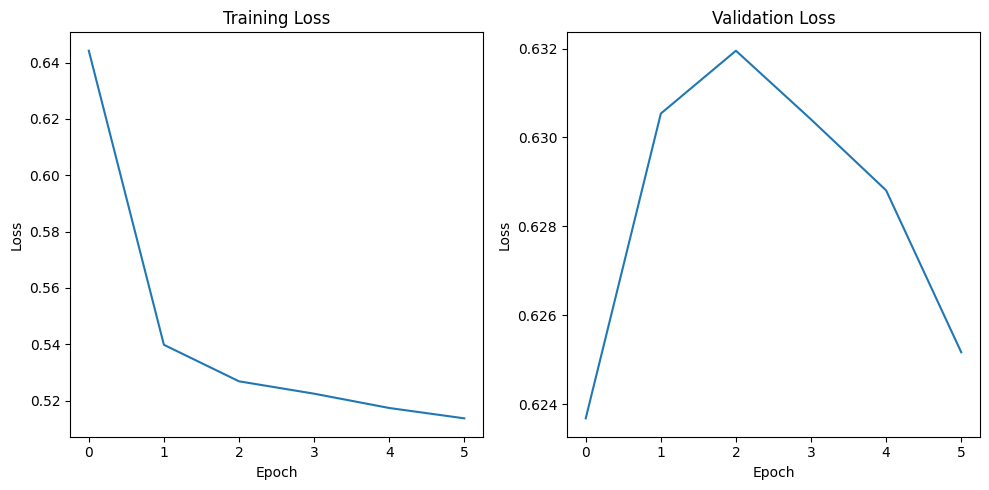

In [9]:
df_result = tuner.plot_results()

In [15]:
df_result

,factors,mlp_user_item_dim,learning_rate,epochs,optimizer,dropout,weight_decay,loss_fn,batch_size,mlp_feature_dims,Hit Ratio@10,NDCG@10,Recall@10
0,16,64,0.0001,50,adam,0.2,0.0050,mse,2048,"{'publishers': [36059, 128], 'developers': [43...",0.004947,0.001698,0.004947
1,64,16,0.0005,50,adagrad,0.5,0.0100,mse,4096,"{'developers': [43743, 128], 'genres': [28, 16...",0.001372,0.000529,0.001372
2,128,32,0.0001,50,adagrad,0.2,0.0001,mse,2048,"{'mm_total_recommendation': [1, 16], 'develope...",0.000164,0.000062,0.000164
3,16,16,0.0001,50,adagrad,0.4,0.0010,bce,4096,"{'developers': [43743, 64]}",0.000041,0.000022,0.000041
4,128,128,0.0001,50,sgd,0.2,0.0500,bce,2048,"{'developers': [43743, 128], 'publishers': [36...",0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,16,128,0.0001,50,adagrad,0.4,0.0050,mse,4096,"{'publishers': [36059, 128]}",0.012097,0.007534,0.012097
61,32,64,0.0005,50,adam,0.1,0.0500,bce,8192,"{'genres': [28, 28], 'publishers': [36059, 64]}",0.001742,0.001568,0.001742
62,64,32,0.0005,50,adam,0.3,0.0001,mse,4096,"{'genres': [28, 32]}",0.000197,0.000126,0.000197
63,128,16,0.0001,50,adam,0.0,0.0100,bce,2048,"{'publishers': [36059, 64], 'genres': [28, 16]}",0.000008,0.000002,0.000008


# Train model with best params

In [11]:
best_param = best_params['Hit Ratio@10']['params']
batch_size = best_param.pop('batch_size')

In [12]:
from helpers.dataloader_custom_functions import collate_fn

dataset_params = {
    'df_features': df_features,
    'feature_dims': best_param['mlp_feature_dims']
}

train_dataset = NCFDataset(df_train, **dataset_params)
val_dataset = NCFDataset(df_val, **dataset_params)

dataloader_params = {
    'batch_size': batch_size,
    'num_workers': 4,
    'persistent_workers': True,
    'prefetch_factor': 4,
    'pin_memory': True,
    'pin_memory_device': 'cuda',
    'collate_fn': collate_fn
}

train_dataloader = DataLoader(train_dataset, shuffle=True, **dataloader_params)
val_dataloader = DataLoader(val_dataset, shuffle=False, **dataloader_params)

model = NCFRecommender(unique_users, unique_items, df_features=df_features, **best_param)
model.fit(train_dataloader, val_dataloader)

Epoch 1/50
Train loss: 0.639750, Validation loss: 0.648771
Epoch 2/50
Train loss: 0.569342, Validation loss: 0.621138
Epoch 3/50
Train loss: 0.534452, Validation loss: 0.629344
Epoch 4/50
Train loss: 0.530070, Validation loss: 0.629125
Epoch 5/50
Train loss: 0.525983, Validation loss: 0.628823
Epoch 6/50
Train loss: 0.523520, Validation loss: 0.627226
Epoch 7/50
Train loss: 0.520669, Validation loss: 0.625241
Early stopping triggered after 7 epochs
Training completed!


In [13]:
evaluator = Evaluation(recommender=model, test_data=df_test)
metrics = evaluator.evaluate()

Creating ground truth sets...
Generating predictions...
Processing 1 of 121682 users... (0.00%)
Memory usage: 0.267333984375
Increased user batch size from 256 to 282
Increased item batch size from 2048 to 2253
Processing 257 of 121682 users... (0.21%)
Memory usage: 0.318359375
Increased user batch size from 282 to 310
Increased item batch size from 2253 to 2478
Processing 539 of 121682 users... (0.44%)
Memory usage: 0.43603515625
Increased user batch size from 310 to 341
Increased item batch size from 2478 to 2726
Processing 849 of 121682 users... (0.70%)
Memory usage: 0.578125
Increased user batch size from 341 to 375
Increased item batch size from 2726 to 2999
Processing 1190 of 121682 users... (0.98%)
Memory usage: 0.75
Increased user batch size from 375 to 413
Increased item batch size from 2999 to 3299
Processing 1565 of 121682 users... (1.29%)
Memory usage: 0.958251953125
Decreased user batch size from 413 to 289
Decreased item batch size from 3299 to 2309
Processing 1978 of 121

In [14]:
for metric in metrics.keys():
    print(f'{metric}:\t{metrics[metric]: .7f}')

Hit Ratio@10:	 0.0369652
NDCG@10:	 0.0177122
Recall@10:	 0.0369652
